# BVP

In [1]:
import numpy as np
import matplotlib.pylab as plt

In [2]:
from scipy.integrate import solve_bvp
from scipy.interpolate import CubicSpline
from scipy.integrate import quad

In [20]:
from scipy.optimize import minimize_scalar

# Parameters

In [30]:
length = 100   # cm, half length of the beam
delta = 0.1  # cm, deflection at the center

E_Young = 100000 # ua

x_mesh = np.linspace(0, length, 17)  # Mesh for bvp_solve

t_max = 6
t_min = 1

In [31]:
conductivity_upper_limit = t_max*length
conductivity_lower_limit = t_min*length

stress_upper_limit = E_Young* 3* t_max*delta/length**2 / 2
stress_lower_limit = E_Young* 3* t_min*delta/length**2 / 2

In [58]:
class Beam():
    
    def __init__(self, thickness_values):
        ''' Define a beam
            
            thickness_values: list of thickness values uniformly distributed between 0 and x=length
        '''
        self.thickness_values = thickness_values
        
        self.x_spline = np.linspace(0, length, len(thickness_values))

        self.thickness = CubicSpline(self.x_spline, thickness_values,
                                    bc_type=('natural', 'natural'))#'clamped'))
        #R, err = quad(lambda x:1/self.thickness(x, nu=0),
        #                        0, length)
        self.conductivity = float(self.thickness.integrate(0, length))
        self.solve_meca()
        
    def flex(self, x):
        ''' Variable flexural rigidity and its derivatives '''
        E = E_Young / 12
        t = self.thickness(x, nu=0)
        dtdx = self.thickness(x, nu=1)
        
        D = E * t**3 
        dD_dx = E * 3*t**2 * dtdx
        d2D_dx2 = E*( 6*t*dtdx**2 + 3*t**2 * self.thickness(x, nu=2) )
        
        return D, dD_dx, d2D_dx2
  

    def solve_meca(self):
        
        def dU_dx(x, U):
            w = U[0]
            dw_dx = U[1]
            d2w_dx2 = U[2]
            d3w_dx3 = U[3]

            D, dD_dx, d2D_dx2 = self.flex(x)
            d4w_dx4 = ( -d2D_dx2*d2w_dx2 -2*dD_dx*d3w_dx3 )/D
            return np.vstack((dw_dx, d2w_dx2, d3w_dx3, d4w_dx4))
        
        def boundary_conditions(ya, yb):
            return np.array([ya[0],  # w(0) = 0
                             ya[1],  # w'(0) = 0
                             yb[0] - delta, # w(L) = delta
                             yb[2]])  # w''(L) = 0
        
        U_zero = np.ones((4, x_mesh.size))
        sol = solve_bvp(dU_dx, boundary_conditions,
                    x_mesh, U_zero)
        
        self.x = sol.x
        self.w = sol.y[0]
        self.k = sol.y[2]
        
        self.sigma =  E_Young * sol.y[2] * self.thickness(self.x)/2
        
        res = minimize_scalar(lambda x:-sol.sol(x)[2]*self.thickness(x)/2*E_Young,
                                         bounds=[0, length], method='Bounded')
        self.max_stress = -res.fun
        
        return sol
    
    
    def merite(self):

        return ((self.conductivity-conductivity_lower_limit)/(conductivity_upper_limit-conductivity_lower_limit),
               (self.max_stress- stress_lower_limit)/(stress_upper_limit -  stress_lower_limit))

In [59]:
conductivity_lower_limit

100

## Define variable flexural rigidity

In [60]:
b_ref = Beam((6, 6))
b_half_lin = Beam((3, 6))
b_half_const = Beam((3, 3))

In [62]:
b_ref.max_stress

8.99999959445624

In [39]:
from scipy.optimize import minimize

In [76]:
def fun(points):
    conductivity, stress = Beam(points).merite()
    
    return (1-conductivity)**2 + 10*stress**2

In [ ]:
res

In [ ]:
opti = res.x

opti_beam = Beam(opti)

plt.plot(x_mesh, opti_beam.thickness(x_mesh), '-+', label='opti');
plt.axhline(y=0);

In [ ]:
plt.figure(figsize=(4, 4))
#plt.plot(*Beam((6, 6)).merite(), 'sr', label='thick');
#plt.plot(*Beam((1, 1)).merite(), 'or', label='thin');

plt.plot(*Beam((6, 1)).merite(), '^k', label='thick-->thin');
plt.plot(*Beam((1, 6)).merite(), 'vb', label='thin-->thick');

plt.plot(*Beam((6, 4, 1)).merite(), 'go', label='thin-->thick');
plt.plot(*Beam((6, 4.45, 1)).merite(), 'ro', label='thin-->thick');
#opti = [5.63575023, 5.44580001, 4.81664833, 1.75389989, 5.08693129,1.40826336]
#plt.plot(*Beam(opti).merite(), 'or', label='opti');

plt.legend();
plt.ylabel('max stress'); plt.xlabel('conductivity');
#plt.xlim([0, 1]); plt.ylim([0, 1]);
plt.plot([0, 1], [0, 1], '--k');

In [ ]:
t_intermediate = np.linspace(1, 8, 25)
u = [fun((6, 2.5, p)) for p in t_intermediate ]

plt.plot(t_intermediate, u, 'r-o');

In [ ]:
print(t_intermediate[np.argmin(u)], min(u))

6, 2.428571428571429:  0.3417313126626329

In [ ]:
opti_beam = Beam([6, 2.3, 1.714])

plt.plot(x_mesh, opti_beam.thickness(x_mesh), '-+', label='opti');
plt.axhline(y=0);

In [ ]:
fun((6, 6, 1, 6, 6))

In [63]:
import itertools as it

In [79]:
min_value = 0.8
for points in it.product(np.linspace(1, 6, 15), repeat=3):
    padded_points = [6, *points]
    score = fun(padded_points)
    if score < min_value:
        print(padded_points, score)
        min_value = score

[6, 1.0, 1.0, 3.857142857142857] 0.7912464510793507
[6, 1.0, 1.0, 4.214285714285714] 0.763771556579339
[6, 1.0, 1.0, 4.571428571428571] 0.7360309600771667
[6, 1.0, 1.0, 4.928571428571429] 0.7095748408440967
[6, 1.0, 1.0, 5.285714285714286] 0.6788870795097279
[6, 1.0, 1.0, 5.642857142857143] 0.6502559054250154
[6, 1.0, 1.0, 6.0] 0.6480365386967825


In [73]:
minimize(fun, padded_points, method='Powell')

/home/etiennenavarro/notebooks/py3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


KeyboardInterrupt: 

In [15]:
min_value = 0.8
for points in it.product(np.linspace(1, 6, 4), repeat=3):
    score = fun(points)
    if score < min_value:
        print(points, score)
        min_value = score

(1.0, 1.0, 4.333333333333334) 0.7666610017607789
(1.0, 1.0, 6.0) 0.6614425712746769
(1.0, 2.666666666666667, 6.0) 0.5163840674139417
(2.666666666666667, 2.666666666666667, 4.333333333333334) 0.4513929712887476
(2.666666666666667, 2.666666666666667, 6.0) 0.35923784557237864
(6.0, 4.333333333333334, 2.666666666666667) 0.3490885376340931


In [ ]:
res

0.6480365386967825


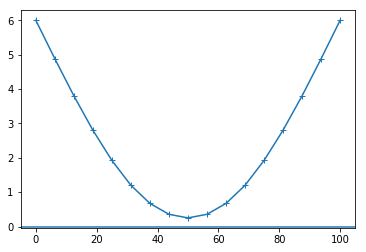

In [80]:
opti_points = [6, 1.0, 1.0, 6.0]
opti_beam = Beam(opti_points)
print(fun(opti_points))
plt.plot(x_mesh, opti_beam.thickness(x_mesh), '-+', label='opti');
plt.axhline(y=0);

In [75]:
opti_beam.max_stress

1.7706691414409101